In [1]:
!pip install pytorch
!pip install transformers
!pip install numpy
!pip install sklearn 
!pip install matplotlib
!pip install tqdm
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
  error: subprocess-exited-with-error
  
  × Running setup.py install for pytorch did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Running setup.py install for pytorch ... error
error: legacy-install-failure

× Encountered error while trying to install package.
╰─> pytorch

note: This is an issue with the package mentioned above, not pip.
hint: See above for output from the failure.
Looking in indexes: ht

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer, set_seed
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
set_seed(123)

In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
#%cd /content/drive/My Drive/GPT2-News-Classifier/
df = pd.read_csv('/content/drive/MyDrive/Security/classifier/CF Trainer Data part1.csv')
df.head()

,text,label
0,A telecommunication service attribute is a spe...,0
1,In this case the mobile station must support a...,0
2,GTP-U Tunnels are used to carry encapsulated T...,0
3,Maintenance of PDCP sequence numbers for radio...,0
4,Thus the source port in this context is the so...,1


In [5]:
#df.groupby("label").size().plot.bar()
df.groupby("label").size()

label
0    1326
1     614
2     461
dtype: int64

In [6]:

print("hello " + str(df['label'][454]) + "lol")

hello 1lol


In [7]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [8]:
example_text = "I will watch Memento tonight"
gpt2_input = tokenizer(example_text, padding="max_length", max_length=10, truncation=True, return_tensors="pt")
print(gpt2_input['input_ids'])
print(gpt2_input["attention_mask"])


tensor([[50256, 50256, 50256,    40,   481,  2342,   337,   972,    78,  9975]])
tensor([[0, 0, 0, 1, 1, 1, 1, 1, 1, 1]])


In [9]:
example_text = tokenizer.decode(gpt2_input.input_ids[0])
print(example_text)

<|endoftext|><|endoftext|><|endoftext|>I will watch Memento tonight


In [10]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
labels = {
    0: 0,
    1: 1,
    2: 2,
         }

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df['text']]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [11]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=35),
                                     [int(0.85*len(df)), int(0.90*len(df))])

print(len(df_train), len(df_val), len(df_test))

2040 120 241


In [12]:

class SimpleGPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)

        
    def forward(self, input_id, mask):
        """
        Args:
                input_id: encoded inputs ids of sent.
        """
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

In [13]:

def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=10)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)
            
            model.zero_grad()

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                output = model(input_id, mask)
                
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc
                
            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")
            
EPOCHS = 15
model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=3, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-5

train(model, df_train, df_val, LR, EPOCHS)

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

100%|██████████| 204/204 [00:17<00:00, 11.93it/s]


Epochs: 1 | Train Loss:  0.096             | Train Accuracy:  0.542             | Val Loss:  0.093             | Val Accuracy:  0.592


100%|██████████| 204/204 [00:14<00:00, 14.42it/s]


Epochs: 2 | Train Loss:  0.083             | Train Accuracy:  0.629             | Val Loss:  0.091             | Val Accuracy:  0.567


100%|██████████| 204/204 [00:14<00:00, 14.46it/s]


Epochs: 3 | Train Loss:  0.067             | Train Accuracy:  0.709             | Val Loss:  0.089             | Val Accuracy:  0.642


100%|██████████| 204/204 [00:14<00:00, 14.47it/s]


Epochs: 4 | Train Loss:  0.048             | Train Accuracy:  0.808             | Val Loss:  0.093             | Val Accuracy:  0.592


100%|██████████| 204/204 [00:14<00:00, 14.47it/s]


Epochs: 5 | Train Loss:  0.031             | Train Accuracy:  0.877             | Val Loss:  0.105             | Val Accuracy:  0.558


100%|██████████| 204/204 [00:14<00:00, 14.42it/s]


Epochs: 6 | Train Loss:  0.017             | Train Accuracy:  0.943             | Val Loss:  0.113             | Val Accuracy:  0.558


100%|██████████| 204/204 [00:14<00:00, 14.43it/s]


Epochs: 7 | Train Loss:  0.009             | Train Accuracy:  0.971             | Val Loss:  0.142             | Val Accuracy:  0.633


100%|██████████| 204/204 [00:14<00:00, 14.44it/s]


Epochs: 8 | Train Loss:  0.006             | Train Accuracy:  0.985             | Val Loss:  0.161             | Val Accuracy:  0.508


100%|██████████| 204/204 [00:14<00:00, 14.45it/s]


Epochs: 9 | Train Loss:  0.004             | Train Accuracy:  0.991             | Val Loss:  0.160             | Val Accuracy:  0.600


100%|██████████| 204/204 [00:14<00:00, 14.43it/s]


Epochs: 10 | Train Loss:  0.003             | Train Accuracy:  0.991             | Val Loss:  0.162             | Val Accuracy:  0.533


100%|██████████| 204/204 [00:14<00:00, 14.43it/s]


Epochs: 11 | Train Loss:  0.003             | Train Accuracy:  0.994             | Val Loss:  0.179             | Val Accuracy:  0.550


100%|██████████| 204/204 [00:14<00:00, 14.43it/s]


Epochs: 12 | Train Loss:  0.002             | Train Accuracy:  0.996             | Val Loss:  0.206             | Val Accuracy:  0.592


100%|██████████| 204/204 [00:14<00:00, 14.46it/s]


Epochs: 13 | Train Loss:  0.004             | Train Accuracy:  0.990             | Val Loss:  0.195             | Val Accuracy:  0.492


100%|██████████| 204/204 [00:14<00:00, 14.44it/s]


Epochs: 14 | Train Loss:  0.002             | Train Accuracy:  0.993             | Val Loss:  0.170             | Val Accuracy:  0.583


100%|██████████| 204/204 [00:14<00:00, 14.41it/s]


Epochs: 15 | Train Loss:  0.002             | Train Accuracy:  0.995             | Val Loss:  0.189             | Val Accuracy:  0.617


In [14]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

        
    # Tracking variables
    predictions_labels = []
    true_labels = []
    
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels
    
true_labels, pred_labels = evaluate(model, df_test)

Test Accuracy:  0.527


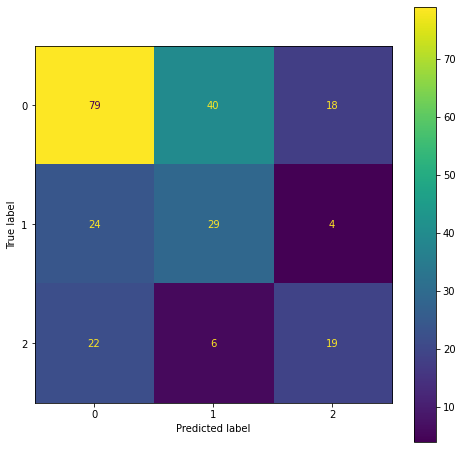

In [15]:
# Plot confusion matrix.
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(labels)), normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.keys()))
disp.plot(ax=ax)

In [16]:

for label in df['label']:
  print(label)

0
0
0
0
1
1
0
1
1
0
1
1
1
1
1
0
0
0
0
0
0
0
1
1
0
0
0
1
1
2
0
0
0
0
1
0
0
1
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
1
0
0
0
1
0
0
0
1
1
0
1
1
1
1
0
0
1
0
0
0
1
1
1
0
1
1
0
0
1
0
0
0
0
1
1
0
1
0
0
1
1
1
1
1
1
0
1
1
1
1
1
1
1
0
0
0
0
0
1
0
0
0
0
0
0
2
1
0
0
2
0
0
0
1
1
1
1
0
1
1
0
0
0
0
1
1
1
1
0
1
1
0
1
1
1
0
1
1
1
0
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
2
2
0
0
2
2
0
2
1
1
1
0
1
0
0
0
1
0
0
0
1
1
1
0
0
0
1
0
0
0
0
0
0
0
1
1
0
1
1
0
1
0
0
1
0
0
1
1
1
1
2
2
1
0
0
1
1
1
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
1
1
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
1
1
0
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
2
0
0
0
0
0
2
0
2
0
0
0
0
1
0
0
2
2
2
1
1
0
2
2
2
0
0
0
0
0
1
1
2
2
2
2
0
1
2
0
2
0
2
1
0
2
2
0
2
2
0
1
0
0
2
0
2
2
1
0
1
2
1
1
0
0
0
0
1
2
2
0
0
1
1
0
2
2
0
0
0
0
0
2
0
2
0
2
1
2
0
2
0
0
1
0
1
1
0
0
0
0
0
0
0
0
1
0
2
0
0
0
1
0
2
0
0
2
1
0
2
0
0
0
0
0
1
0
0
2
2
1
2
0
1
1
1
1
1
1
1
1
1
0
0
1
2
2
2
2
1
1
1
0
0
0
0
1
1
1
1
2
2
2
0
0
0
1
2
2
1
1
1
0
0
0
0
0
0
1
1
0
0
0
0
0
0
